In [742]:
import pandas as pd
import numpy as np

In [965]:
owid_covid19 = pd.read_csv('./dataset/OWID/owid-covid-data.csv')
owid_covid19.head(2) 

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [1047]:
owid_covid19_spain=owid_covid19.query('location=="Spain"')[160:]
day_num=list(range(1,owid_covid19_spain.shape[0]+1))
owid_covid19_spain['day_num']=day_num
owid_covid19_spain.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,day_num
33498,ESP,Europe,Spain,2020-06-08,241717.0,167.0,297.000,27136.0,0.0,1.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,1
33499,ESP,Europe,Spain,2020-06-09,241966.0,249.0,290.571,27136.0,0.0,1.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,2


In [1010]:
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

In [1011]:
def fit_logistic(all_data,train_lim, target):
    data_cp = all_data.copy()
    y = data_cp[:train_lim][target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

In [1053]:
def plot_logistic(x, y, y_fit,country_name,target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on 2020-06-08)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ country_name)

In [1054]:
def plot_logistic_country(all_data, train, valid_num, country_name,target, x, a_, b_, c_, d_):
    forecast = logistic_function(list(range(len(x)+60)), a_, b_, c_, d_)
    df_train = train[target][:]
    df_fcst = forecast[:len(df_train)]
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual new cases vs predictions based on Logistic curve for "+country_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on 2020-06-08")
    ax1.set_ylabel("ConfirmedCases")

In [1055]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize

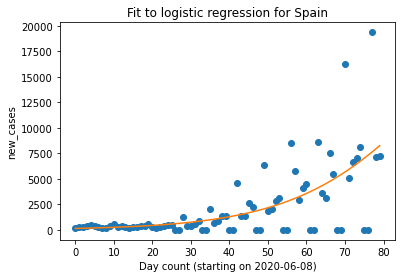

In [1056]:
# Fit country to logistic curve
train_lim = 80
valid_lim = 119 # needs to be changed as more days of training data are included
#test_lim = 112
valid_num=valid_lim-train_lim 
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(owid_covid19_spain, train_lim, 'new_cases')
plot_logistic(x, y, y_fit,'Spain','new_cases')

In [1057]:
train=owid_covid19_spain[:train_lim]
train

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,day_num
33498,ESP,Europe,Spain,2020-06-08,241717.0,167.0,297.000,27136.0,0.0,1.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,1
33499,ESP,Europe,Spain,2020-06-09,241966.0,249.0,290.571,27136.0,0.0,1.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,2
33500,ESP,Europe,Spain,2020-06-10,242280.0,314.0,279.143,27136.0,0.0,1.143,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,3
33501,ESP,Europe,Spain,2020-06-11,242707.0,427.0,292.429,27136.0,0.0,0.429,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,4
33502,ESP,Europe,Spain,2020-06-12,243209.0,502.0,318.714,27136.0,0.0,0.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33573,ESP,Europe,Spain,2020-08-22,386054.0,0.0,6177.286,28838.0,0.0,31.571,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,76
33574,ESP,Europe,Spain,2020-08-23,386054.0,0.0,6177.286,28838.0,0.0,31.571,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,77
33575,ESP,Europe,Spain,2020-08-24,405436.0,19382.0,6622.000,28872.0,34.0,32.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,78
33576,ESP,Europe,Spain,2020-08-25,412553.0,7117.0,6908.143,28924.0,52.0,36.286,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,79


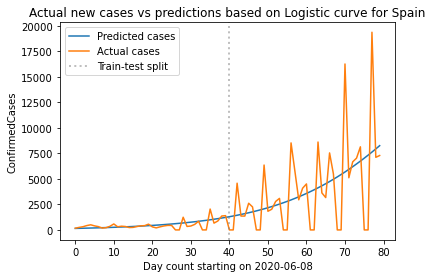

In [1058]:
plot_logistic_country(owid_covid19_spain, train, valid_num, 'Spain','new_cases', x, a_, b_, c_, d_)

- 重复预测并将结果传入

In [1022]:
def fit_logistic_new(all_data,train_num,target,day_num):
    data_cp = all_data.copy()
    y = data_cp[-train_num:].astype(np.int32)
    #x = list(range(day_num-train_num, day_num)) # x 值有问题
    x = list(range(0, len(y)))
    # Initial guess 参数的初始猜测
    p0 = [0,1,1,0]
    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

In [1023]:
def plot_logistic(x, y, y_fit,country_name,target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on 2020-06-18)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ country_name)

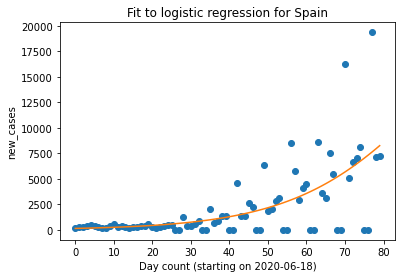

In [1024]:
# Fit country to logistic curve
train_num = 80
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic_new(owid_covid19_spain['new_cases'], train_num, 'new_cases',200)
plot_logistic(x, y, y_fit,'Spain','new_cases')

In [1025]:
new_train=pd.Series(y_fit[-40:])

In [1026]:
new_data=owid_covid19_spain['new_cases'][-40:].append(new_train)
new_data

33538       0.000000
33539       0.000000
33540    4581.000000
33541    1358.000000
33542    1357.000000
            ...     
35       7034.556142
36       7329.569398
37       7632.441341
38       7943.009109
39       8261.077369
Length: 80, dtype: float64

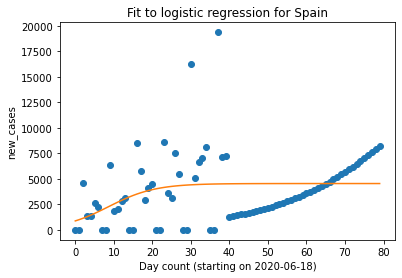

In [1000]:
# Fit country to logistic curve
train_num = 80
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic_new(new_data, train_num, 'new_cases',200)
plot_logistic(x, y, y_fit,'Spain','new_cases')